# Faraday Complexity: A How to Guide

In this Jupyter notebook, we'll give an overview of how our scripts work and how to utilize them for constructing and training neural networks to identify complex Faraday sources.

## Generating data with possum and simulate

The modules **possum** and **simulate** are used to generate data. By itself, the functions with possum are more focused on creating a spectrum for a single source, while the inherited functions from simulate allow us to generate a large number of sources with a few function calls.

Let's begin by importing the possum class. Since possum inherits simulate, it will automatically load as well.

In [1]:
from possum import *

There are a few frequency bands that are already part of the possum class: 

    ASKAP 12 (700 - 1300 MHz, 1500 - 1800 MHz)
    ASKAP 36 (1130 - 1430 MHZ)
    Westerbork Synthesis Radio Telescope (WRST, 310 - 380 MHz)

These can be created by calling the functions

    _createASKAP12()
    _createASKAP36()
    _createWSRT()
    
which store the frequencies (in Hz) in the variable 

    nu_
    
If you need another frequency range, the function **\_createFrequency** will be of good use. It's function call is:

    _createFrequency(numin, numax, nchan, store=False)

It takes four parameters: the minimum (***numin***) and maximum (***numax***) frequencies, as well as the number of channels (***nchan***) and a ***store*** parameter. If you would like to store the results in ***self.nu\_***, then set ***store=True***; otherwise the frequency array will be returned. 
    
As an example of how the functions within this class work, we can create the ASKAP 12 coverage by running the following commands and verify that our range is over the proper frequency range:

In [2]:
spec = possum()
spec._createASKAP12()

print('Min Frequency (Hz): {:e}'.format(spec.nu_.min()))
print('Max Frequency (Hz): {:e}'.format(spec.nu_.max()))

Min Frequency (Hz): 7.000000e+08
Max Frequency (Hz): 1.800000e+09


### Polarization Spectra

Simple and complex polarization spectra can both be created using the **\_createNspec** function, which takes in the parameters ***flux***, ***depth***, ***chi***, and ***sig***, where flux is the strength of the source, depth is the Faraday depth, chi is the phase $\chi$, and sig(ma) is the standard deviation of the noise $\sigma$. The function call is as follows

    _createNspec(flux, depth, chi, sig)
    
For complex sources, one passes in the flux, depth, and chi as an array or list. The polarization spectra is stored in the variable

    polarization_

As an illustration, let's create a polarization spectrum of a simple and a complex source and plot the real ($Q$) and imaginary ($U$) components. We'll create a custom frequency range to illustrate the **\_createFrequency** function.

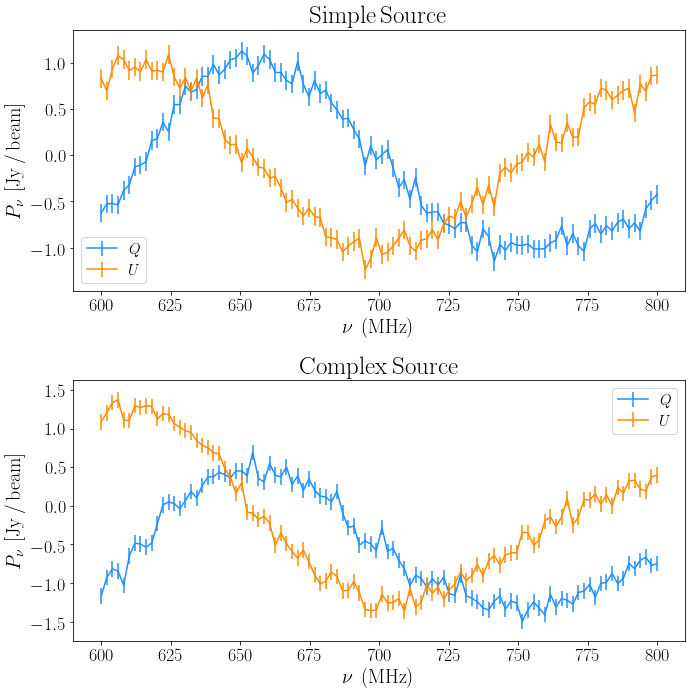

In [3]:
spec = possum()
spec._createFrequency(600, 800, 100, store=True)

# ==========================================================
# Convert frequency to MHz for plotting purposes
# ==========================================================
nu = spec.nu_ / 1e6


plt.figure(1, figsize=(10,10))
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=18)

# ==========================================================
# Plot the polarization spectrum of the simple source
# ==========================================================
flux1 = 1   
depth1 = 30
chi1 = 0
sig = 0.1

spec._createNspec(flux1, depth1, chi1, sig)

plt.subplot(2,1,1)
plt.errorbar(nu, spec.polarization_.real, yerr=sig, label=r'$Q$', color='dodgerblue')
plt.errorbar(nu, spec.polarization_.imag, yerr=sig, label=r'$U$', color='darkorange')
plt.xlabel(r'$\nu \: \left(\mathrm{MHz}\right)$', fontsize=20)
plt.ylabel(r'$P_\mathrm{\nu} \: \left[\rm Jy \, / \, beam\right]$', fontsize=20)
plt.title(r'$\rm Simple \, Source$', fontsize=25)
plt.tight_layout()
plt.legend(loc='best', fontsize=15)

# ==========================================================
# Plot the polarization spectrum of the complex source
# ==========================================================

flux2 = [1, 0.5]
depth2 = [30, -10]
chi2 = [0, 0.5]
sig = 0.1

spec._createNspec(flux2, depth2, chi2, sig)

plt.subplot(2,1,2)
plt.errorbar(nu, spec.polarization_.real, yerr=sig, label=r'$Q$', color='dodgerblue')
plt.errorbar(nu, spec.polarization_.imag, yerr=sig, label=r'$U$', color='darkorange')
plt.xlabel(r'$\nu \: \left(\mathrm{MHz}\right)$', fontsize=20)
plt.ylabel(r'$P_\mathrm{\nu} \: \left[\rm Jy \, / \, beam\right]$', fontsize=20)
plt.title(r'$\rm Complex \, Source$', fontsize=25)
plt.tight_layout()
plt.legend(loc='best', fontsize=15)
plt.show()

### Faraday Rotation

The Faraday rotation spectra can be created using the function **\_createFaradaySpectrum**, which takes in two parameters: the minimum (***philo***) and maximum (***phihi***) Faraday depths:

    _createFaradaySpectrum(philo, phihi)
    
and stores the rotation measure $\phi$ and the source spectrum in the following variables:

    phi_
    faraday_
    
In the script below, we generate the Faraday spectrum of the polarization spectrum show above and plot the real and imaginary components, along with their magnitude. The faraday depths for the two sources are indicated by vertical dashed lines.

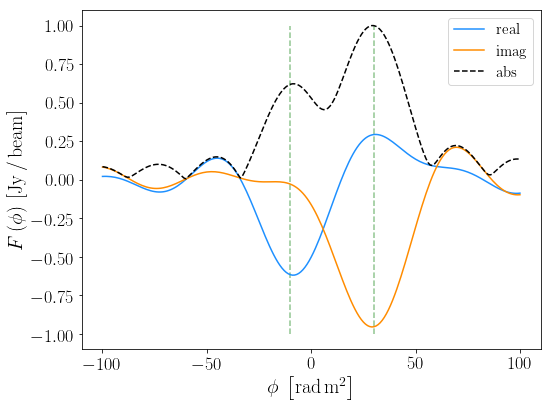

In [4]:
spec._createFaradaySpectrum(-100, 100)

plt.figure(1, figsize=(8, 6))

# ==================================================
# Plot the real, imag, and abs value
# ==================================================
plt.plot(spec.phi_, spec.faraday_.real, label=r'$\rm real$', color='dodgerblue')
plt.plot(spec.phi_, spec.faraday_.imag, label=r'$\rm imag$', color='darkorange')
plt.plot(spec.phi_, np.abs(spec.faraday_), label=r'$\rm abs$', color='black', linestyle='dashed')

# ==================================================
# Add the two faraday depths to the plot
# ==================================================
plt.vlines(x=depth2, ymin=-1, ymax=1, linestyle='dashed', color='forestgreen', alpha=0.5)

# ==================================================
# Add labels and display
# ==================================================
plt.xlabel(r'$\phi \: \left[\rm rad \, m^{2}\right]$', fontsize=20)
plt.ylabel(r'$F\left(\phi\right) \: \left[\mathrm{Jy \, / \, beam}\right]$', fontsize=20)
plt.legend(loc='best', fontsize=15)
plt.tight_layout()
plt.show()

### Generating Parameters for a Large Number of Spectra

That's everything you need to generate a simulated polarization and faraday spectra using the possum class. To generate a large number of sources, we turn ourselves to the functions inside the **simulate** class.

The function **\_generateParams** will generate parameters for $N$ sources, with the phase $\chi$, depth $\phi$, and flux values stored as a tuple for the complex sources. The parameters are randomly sampled over a uniform distributed between the chosen minimum and maximum values. The function call is of the form

    _generateParams(N, depthMin=-50, depthMax=50, 
            fluxMin=0.01, fluxMax=1, chiMin=0, chiMax=np.pi,
            noiseMin=0.01, noiseMax=1.0, pcomplex=0.35, seed=8595)

where ***N*** is the number of spectral parameters to generate and ***pcomplex*** is the probability that the source is complex. ***seed*** sets the random seed number, while the other parameters set the range of values to sample over. The flux of the first component is set to 1, while the parameters ***fluxMin*** and ***fluxMax*** refer only to the strength of the second component.

Note that ***noiseM--*** refers to the standard deviation of the noise; the notation "noise" is a bit inconsistence with the remaining parts of the class, which all reference the noise via the parameter *sig*.

The sampled values are stored in the arrays

    chi_
    depth_
    flux_
    sig_
    
while the label of the source (simple = 0, complex = 1) is stored in the array

    label_

As an example, we can generate parameters for 5 spectra with a complex probabliity of 50% by the following commands:

In [5]:
spec = possum()
spec._generateParams(5, pcomplex=0.5)

and output the parameters by printing the appropriate variables. Note that the ***complex source parameters*** are stored as ***tuples***.

In [6]:
print('Label: {:}'.format(spec.label_))

print('\nChi:')
for chi in spec.chi_:
    print(chi)

print('\nDepth:')
for depth in spec.depth_:
    print(depth)

print('\nFlux:')
for flux in spec.flux_:
    print(flux)

print('\nSig: {:}'.format(spec.sig_))

Label: [0 1 1 0 1]

Chi:
1.996654415304677
(1.4993887226129559, 2.0337056314566455)
(2.0786187129254965, 1.1950646833073391)
0.48824726584560624
(3.111727180498492, 1.7354112811360209)

Depth:
-15.456539473614328
(45.886628324499085, 10.420263870442191)
(-31.357067397741133, -22.044881740877852)
14.411342509558438
(-12.31841902116905, -11.848637528561333)

Flux:
1.0
(1.0, 0.49110979679184952)
(1.0, 0.94308157062595444)
1.0
(1.0, 0.90104257127624687)

Sig: [ 0.5520234   0.12991986  0.97540935  0.63962429  0.73916718]


### Generating a Large Number of Spectra

The function call of **\_simulateNspec** is as follows:

    _simulateNspec(N=5, pcomplex=0.35, width=100, center=False,
                    seed=8008, save=False, dir='./', timeit=False)
                    
The function first checks to see if the function **\_generateParams** has been previously run by checking if the parameter variable ***self.label\_*** has been stored. If not, then the function runs **\_generateParams** using the defaut parameter ranges, but inserting ***pcomplex*** and ***seed*** into the function call.

With the generated parameters, the function then iterates through each parameter space and generates both the polarization and Faraday spectra, storing the results in the 3D tensors

    X_
    S_
    
where ***X\_*** is the Faraday spectra and ***S\_*** is the polarization spectra. The first dimension of each tensor is the oberservation instance (that is, it has length $N$). The second dimension contains the spectra, while the third dimension is for the real (0) and imaginary (1) components. The $Q$ and $U$ values can be accessed via

    Q = S_[:,:,0]
    U = S_[:,:,1]
    
The ***width*** parameter is used for cropping the Faraday spectrum. If ***center*** is set to true, then the cut is +/- width from the peak in the spectrum (otherwise at $\phi=0$). If the spectra is noisy, centering may cause some issues.

The parameter ***save*** is a boolean asking whether to save the spectra (and parameters) as numpy arrays, and ***dir*** is a path to the directory that you want the arrays to be save to. If the directory doesn't exist, then the function creates the directory.

The final parameter ***timeit*** is a boolean to keep track of how long it takes to run. It will output the total time in minutes once the script is complete.

In the following cell, 6 complex spectra are created using the default ranges in **\_generateParams**:

In [7]:
spec = possum()
spec._simulateNspec(N=6, pcomplex=1.0, width=250)

print("Shape of X_: {:}".format(spec.X_.shape))
print("Shape of S_: {:}".format(spec.S_.shape))

Shape of X_: (6, 501, 2)
Shape of S_: (6, 900, 2)


The real, imaginary, and absolute values of the Faraday spectrum are shown in the plot below:

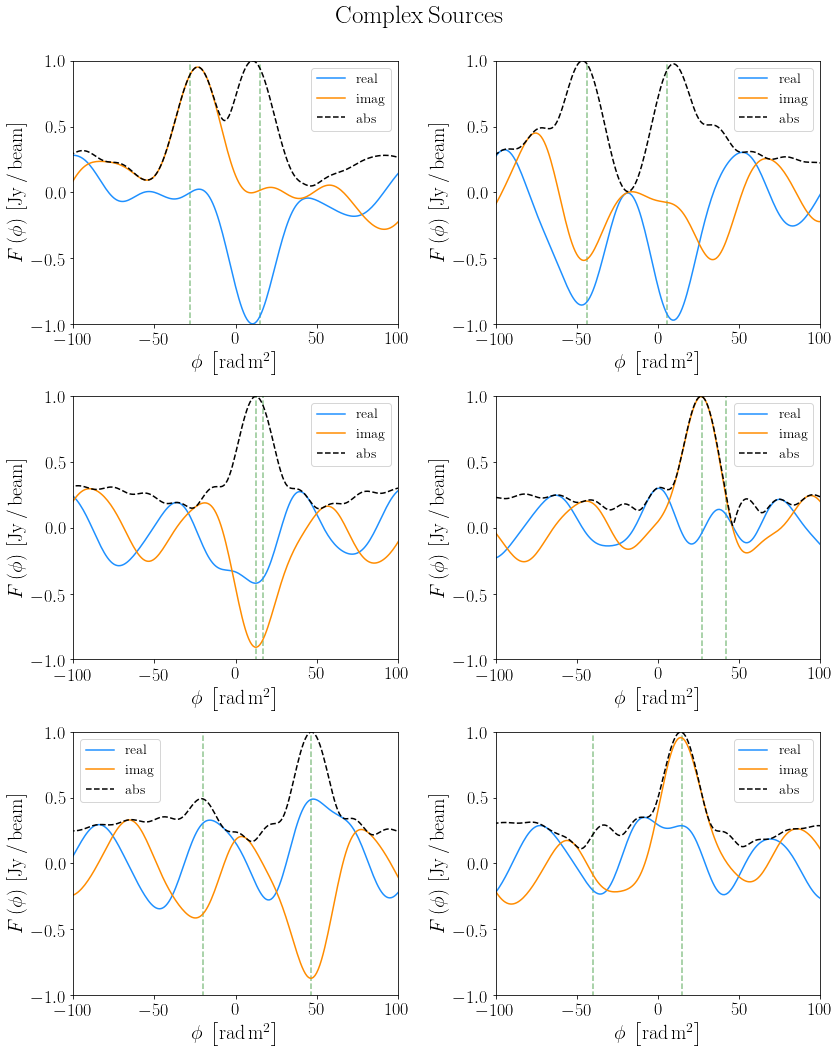

In [8]:
plt.figure(figsize=(12,15))

for s, _ in enumerate(spec.label_):
    plt.subplot(3,2,s+1)
    plt.plot(spec.phi_, spec.X_[s,:,0], color='dodgerblue', label=r'$\rm real$')
    plt.plot(spec.phi_, spec.X_[s,:,1], color='darkorange', label=r'$\rm imag$')
    plt.plot(spec.phi_, np.abs(spec.X_[s,:,0] + 1j*spec.X_[s,:,1]), 'k--', label=r'$\rm abs$')

    plt.vlines(x=spec.depth_[s], ymin=-1.2, ymax=1.2, linestyle='dashed', color='forestgreen', alpha=0.5)
    
    plt.xlim(-100, 100)
    plt.ylim(-1, 1)

    plt.xlabel(r'$\phi \: \left[\rm rad \, m^{2}\right]$', fontsize=20)
    plt.ylabel(r'$F\left(\phi\right) \: \left[\mathrm{Jy \, / \, beam}\right]$', fontsize=20)
    plt.legend(loc='best', fontsize=14)
    
plt.suptitle(r'$\rm Complex \, Sources$', fontsize=25)
plt.tight_layout()
plt.subplots_adjust(top=0.93)

plt.show()

This concludes our discussion of the data generation process. In the next session, we will look at creating a 1D convolutional neural network (CNN) using the inception class, as well as how to utilize some of the analysis and plot functions that come with it.

## Building CNNs with inception

Recently, there has been a shift away from traditional CNNs to an "inception" developed by the GoogLeNet team [(Szegedy et al. 2014)](http://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf). In the inception model a series of convolutions is done in parallel, each with a different kernel size. A key feature of the inception model, however, is the 1x1 convolution (which replaces MaxPooling from earlier CNN models) that serves to collapse the data at intervals. To build an inception model, we can use the functions within the **inception** module.

In [9]:
from inception import *
cnn = inception()

Using TensorFlow backend.


We can create a simple inception layer using the ***\_inception*** function, whose call is of the form

    _inception(convl=[3,5], pool=[3], act='relu', strides=2, padding='same')

The parameters of the **\_inception** function allows us to simply and succinctly create a multitude of inception variations. For instance, the arguments **[3,5,23], pool=[3]** create four "branches;" one with a kernel of size 3, one with a kernel of size 5, one with a kernel of size 23, and one max-pooling branch. Then, we want to add another inception cell in sequence, we can simply call **\_inception([a,b,...,k], pool=[p])**.

Before using this function, however, we first have to load in a training dataset so that the module can extract the input dimensions. The following functions can be used to load in a dataset and are part of the **loadData** module, inherited by **inception**

    _loadTrain(dir)
    _loadTest(dir)
    _loadValid(dir)
    
Each function takes in the directory for the corresponding dataset and opens the necessary files. Since we have a training and validation stored in the directories "data/train" and "data/valid", let's load these datasets

In [10]:
cnn._loadTrain('data/train')
cnn._loadValid('data/valid')

For the training dataset, the following variables are created

    trainX_
    trainY_
    trainLabel_
    trainChi_
    trainDepth_
    trainFlux_
    trainSig_
    
The variable ***trainX\_*** contains the feature tensor for the $N$ faraday spectra, while ***trainY\_*** contains the labels in a format readily usable by Keras. The original labels are stored in the variable ***trainLabel\_***, while the remaining four variables hold the parameters that generated the data.

With the dataset loaded, we can now construct an CNN with an initial inception layer. Let's use the convolution kernels 3, 5, and 23 (the FWHM)

In [11]:
cnn._inception(convl=[3,5,23])

If we want more layers, we can just call the inception function more times. Note, however, that the function **\_inception** is only a basic block and doesn't implement batch normalization, and consequently is only able to produce workable models that contain up to 2 inception layers. The function **\_inception2** implements batch normalization along with an activation function, so this function should be used when constructing deeper networks.

To finish constructing a 1-layer inception model, we need to add the final few layers. We first need to flatten our tensor, which can be done using the function **\_flatten**

In [12]:
cnn._flatten()

We can then add a couple fully connected (Dense) layers using the function **\_dense**,

    _dense(z, act='relu', drop=0.5, nlayers=1)

where ***z*** is the number of neurons in the hidden layer, ***act*** is the activation function, ***drop*** is the dropout rate, and ***nlayers*** is the number of hidden layers to create. So to add two hidden layers with 512 neurons / layer and passing through the ELU activation function, we would just run the following

In [13]:
cnn._dense(512, act='elu', drop=0.5, nlayers=2)

To complete our model, we can compile it using the function **\_compile**, whose function call is

    _compile(classes=2, act='softmax', optimizer='adadelta', loss='binary_crossentropy', 
                metrics=['binary_accuracy'], weights=None)
                
The parameter ***classes*** is the number of output classes that we are trying to predict (which is 2 in our case: simple or complex), while ***optimizer*** is the optimization method we would like to use.

In [14]:
cnn._compile()

In the **plots** module, there is a function 

    _plotCNN(to_file)
    
which will plot our model and save it to the file "to_file". Let's save a plot of our CNN and display the image

In [15]:
cnn._plotCNN('tmp/i1layer.png')

<img src="tmp/i1layer.png" width="500" />

As another example, let's build an even deeper network

In [16]:
from inception import *
cnn = inception()

cnn._loadTrain('data/train/')
cnn._inception2(convl=[3,5,7],  pool=[3,7])
cnn._inception2(convl=[3,5,9],  pool=[3,7])
cnn._inception2(convl=[3,5,13], pool=[3,7])
cnn._inception2(convl=[3,5,17], pool=[3,7])
cnn._inception2(convl=[3,5,22], pool=[3,7])
cnn._convl()
cnn._flatten()
cnn._dense(512, act='elu', drop=0.5, nlayers=3)
cnn._compile(optimizer='rmsprop')
cnn._plotCNN(to_file='tmp/i5layer.png')

<img src="tmp/i5layer.png" width="500" />

## Analyzing an Imbalanced Dataset using plots and analysis

In this section we'll examine the performance of a trained model on an imbalanced dataset with 100,000 sources (~3% complex) using the ***plots*** and ***analysis*** modules.

The model we will be using is a 2-layer inception model, which was trained on 30,000 sources and validated on 10,000 sources (each ~50% complex) with GPUs using the [Argon](https://wiki.uiowa.edu/display/hpcdocs/Argon+Cluster) cluster at the University of Iowa. The model architecture is displayed below.

<img src="models/img/i2layer.png" width="800" />

The logfile is stored at "model/log/i2layer_final.log". We can load in the logfile using the **\_loadLog** function and display the accuracy and loss using the fuctions **\_plotAcc** and **\_plotLoss**. The **\_loadLog** functions takes in the filename as an input parameter:

    _loadLog(logfile)
    
while the calls for the plotting functions are

    _plotLoss(logfile=None, save=False, to_file='loss_vs_epoch.pdf', fontsize=20)
    _plotAcc(logfile=None, save=False, to_file='acc_vs_epoch.pdf', fontsize=20)
    
***save*** is a boolean to indicate whether to save the image to ***to\_file***; ***fontsize*** is used for adjusting the size of the axes labels. If ***logfile*** is not equal to "None", then the function attempts to load in the logfile; otherwise it will attempt to access a pre-loaded logfile.

Using TensorFlow backend.


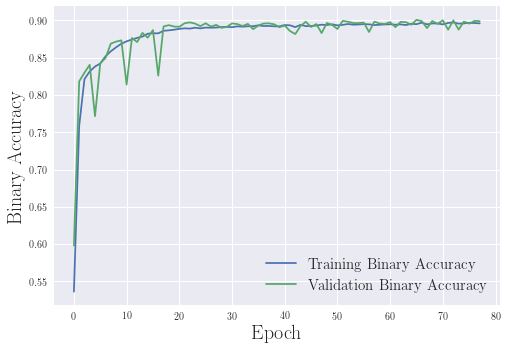

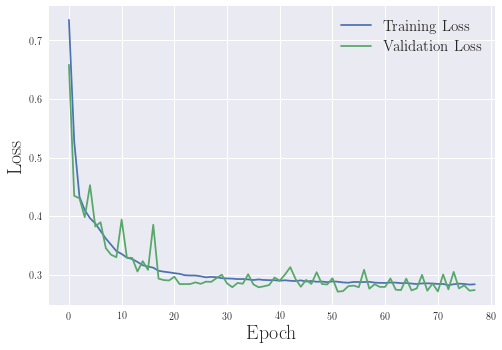

In [1]:
from inception import *
cnn = inception()

cnn._loadLog('models/log/i2layer_final.log')

cnn._plotAcc()
cnn._plotLoss()

In this case the model was subjected to Early Stopping by monitoring the validation loss with a patience of 25 epochs. The lowest validation loss occured for epoch = 51 (index starting at 0), although there is a slight downward trend, suggesting we may be able to get slightly better results by running for a larger number of epochs. However, running more epochs was found to produce only a marginal improvement at best.

The best-fit model is saved in "models/model/i2layer_final.h5" and we can load it using the **\_loadModel** function in ***inception***:

In [2]:
cnn._loadModel('models/model/i2layer_final.h5')

To evaluate its performance, we can load in the test set using the **\_loadTest** function and passing in the appropriate directory, which in this case is "data/test"

In [4]:
cnn._loadTest('data/test/')

We can then use our trained model to predict the type of faraday spectrum for each instance using a 50% threshold for being classified as a complex source

In [6]:
cnn._test(prob=0.50)

and check the confusion matrix, which has already been loaded from ***sklearn***

In [7]:
confusion_matrix(cnn.testLabel_, cnn.testPred_)

array([[93884,  3129],
       [  484,  2503]])

So most of the sources that were predicted to be complex aren't complex due to the large class imbalance. Another way to evaluate the model performace is to plot an ROC curve, which is conveniently included in the ***plots*** module as the function **\_plotROC**. The *area under the curve* (auc) is computed and stored in the variable ***self.auc_***, so can can check this value as well. 

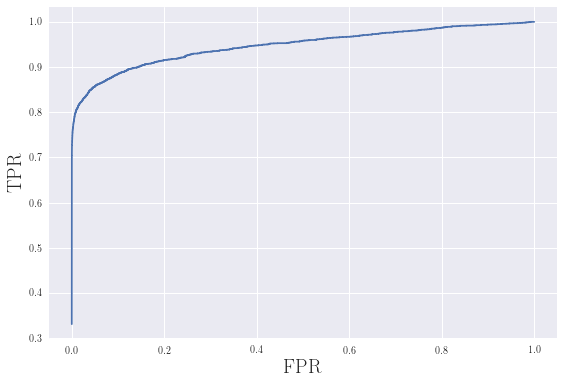

0.94721347058464256

In [14]:
cnn._plotROC()
print(cnn.auc_)

We can separate the complex and simple sources and store their parameters in a dataframe by calling the functions **\_getComplexParams** and **\_getSimpleParams**, which create the pandas dataframes ***self.dfComplex\_*** and ***self.dfSimple\_*** respectively. These can be created at the same time using the function 

    _getParams(prob)
    
which takes the threshold probability ***prob*** as an input parameter for labelling a source as simple or complex. These are often created automatically when calling plotting functions within the ***plots*** module.

In [20]:
cnn._getComplexParams()
cnn._getSimpleParams()
cnn._getParams()

print("Complex: \n{:}".format(cnn.dfComplex_.head()))
print("\nSimple: \n{:}".format(cnn.dfSimple_.head()))
print("\nCombined: \n{:}".format(cnn.dfParams_.head()))

Complex: 
        chi      depth      flux      prob       sig  indx
0  1.601622  17.093742  0.083455  0.435628  0.620571     7
1  0.600794   4.497386  0.144556  0.558818  0.934183    52
2  1.662153  27.576426  0.504849  0.999953  0.218603    62
3  0.411117  16.980184  0.516300  1.000000  0.761835    65
4  0.534897   0.448696  0.595159  0.093902  0.307079    76

Simple: 
         chi    depth flux      prob       sig  indx
0    3.05029  35.7573    1  0.109815  0.314491     0
1  0.0252689 -22.3837    1  0.123668  0.549402     1
2   0.460934 -5.68358    1  0.126907  0.772864     2
3     2.7611  -27.924    1  0.111531  0.033569     3
4    2.09283  -5.2363    1  0.097072  0.667111     4

Combined: 
       prob  pred  label
0  0.435628     0      1
1  0.558818     1      1
2  0.999953     1      1
3  1.000000     1      1
4  0.093902     0      1


We can do some simple comparisons to see how the various parameters (chi, depth, flux, sig) are related to the probability outputs for the complex sources using the **\_plotParamProb** function, whose function call is as follows:

    _plotParamProb(param, kind='kde', gridsize=50, 
               save=False, to_file="FluxProb.pdf", fontscale=1.25)
           
***param*** is a string that identifies the column name in the dataframe ("chi", "depth", "flux", "sig"). Let's see how well the flux of the second component affects our model's prediction:

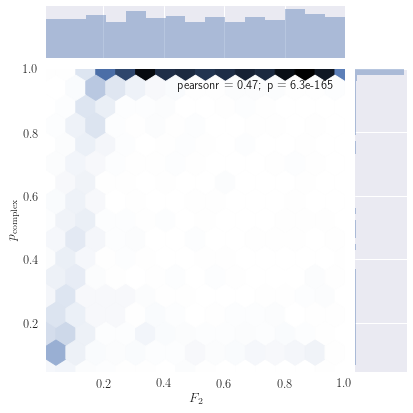

In [24]:
cnn._plotParamProb('flux', kind='hex', gridsize=15)

The model has a steep drop once the fluxes get below 0.2, but is doing quite well otherwise. Let's check how the model performs on the (absolute) difference in the two Faraday components.

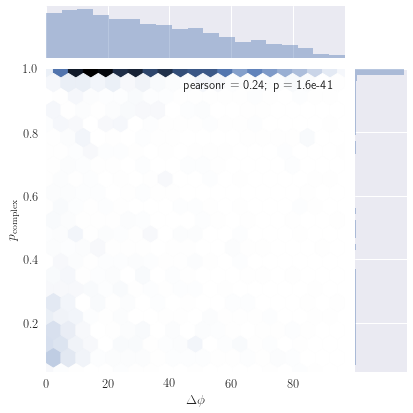

In [33]:
cnn._plotParamProb('depth', kind='hex', gridsize=20)

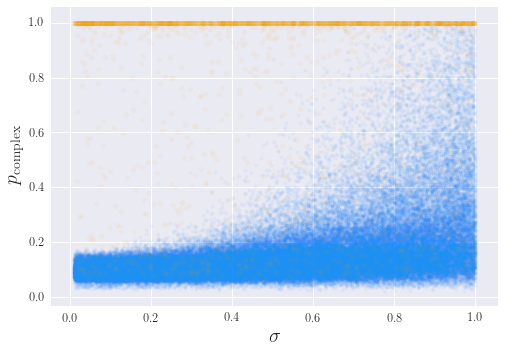

In [18]:
plt.figure(1)
plt.scatter(cnn.dfSimple_['sig'], cnn.dfSimple_['prob'], color='dodgerblue', alpha=0.05, s=10)
plt.scatter(cnn.dfComplex_['sig'], cnn.dfComplex_['prob'], color='orange', alpha=0.05, s=20)
plt.xlabel(r'$\sigma$', fontsize=20)
plt.ylabel(r'$p_\mathrm{complex}$', fontsize=20)
plt.show()